In [1]:
from ultralytics import YOLO
from glob import glob
import os

# ---------------------------------------------------
# CONFIG
# ---------------------------------------------------
ROOT_IMG_DIR = r"C:/Users/avant/Downloads/multi_images/multi_images"
ROOT_LABEL_DIR = r"C:/Users/avant/Downloads/multi_images/pseudo_labels"

WEATHERS = ["clear", "foggy", "rainy"]

CAMERAS = [
    "CAM_FRONT",
    "CAM_FRONT_LEFT",
    "CAM_FRONT_RIGHT",
    "CAM_BACK",
    "CAM_LEFT",
    "CAM_RIGHT",
]

# COCO classes to keep
KEEP_CLASSES = {0, 1, 2, 3, 5, 7}

# ✅ Weather-specific confidence thresholds (THIS is correct)
WEATHER_CONF = {
    "clear": 0.45,
    "foggy": 0.30,
    "rainy": 0.35,
}

# ---------------------------------------------------
# LOAD YOLO
# ---------------------------------------------------
model = YOLO("yolov8n.pt")
print("YOLO model loaded")

# ---------------------------------------------------
# MAIN LOOP
# ---------------------------------------------------
for weather in WEATHERS:
    conf_thres = WEATHER_CONF[weather]
    print(f"\n=== WEATHER: {weather} | conf = {conf_thres} ===")

    weather_img_root = os.path.join(ROOT_IMG_DIR, weather)
    if not os.path.exists(weather_img_root):
        print("[WARN] Missing:", weather_img_root)
        continue

    scene_dirs = sorted(
        d for d in glob(os.path.join(weather_img_root, "scene_*"))
        if os.path.isdir(d)
    )

    for scene_dir in scene_dirs:
        scene_name = os.path.basename(scene_dir)
        print(f"  Scene: {scene_name}")

        for cam in CAMERAS:
            cam_img_dir = os.path.join(scene_dir, cam)
            if not os.path.exists(cam_img_dir):
                continue

            cam_label_dir = os.path.join(
                ROOT_LABEL_DIR, weather, scene_name, cam
            )
            os.makedirs(cam_label_dir, exist_ok=True)

            img_paths = sorted(
                glob(os.path.join(cam_img_dir, "*.jpg")) +
                glob(os.path.join(cam_img_dir, "*.png"))
            )

            for img_path in img_paths:
                results = model(
                    img_path,
                    conf=conf_thres,
                    verbose=False
                )[0]

                lines = []
                if results.boxes is not None:
                    for box, cls in zip(
                        results.boxes.xywhn,
                        results.boxes.cls,
                    ):
                        cls = int(cls)
                        if cls not in KEEP_CLASSES:
                            continue

                        x, y, w, h = box.tolist()
                        lines.append(f"{cls} {x} {y} {w} {h}\n")

                label_path = os.path.join(
                    cam_label_dir,
                    os.path.splitext(os.path.basename(img_path))[0] + ".txt"
                )

                if lines:
                    with open(label_path, "w") as f:
                        f.writelines(lines)

    print(f"✅ Done weather: {weather}")

print("\n✅ All pseudo-labels generated")


YOLO model loaded

=== WEATHER: clear | conf = 0.45 ===
  Scene: scene_0001
✅ Done weather: clear

=== WEATHER: foggy | conf = 0.3 ===
  Scene: scene_0001
✅ Done weather: foggy

=== WEATHER: rainy | conf = 0.35 ===
  Scene: scene_0001
✅ Done weather: rainy

✅ All pseudo-labels generated


In [2]:
import random

root_labels = ROOT_LABEL_DIR
weather = "clear"
scene = "scene_0001"
cam = "CAM_FRONT"

cam_label_dir = os.path.join(root_labels, weather, scene, cam)
some_txt = random.choice([f for f in os.listdir(cam_label_dir) if f.endswith(".txt")])

path = os.path.join(cam_label_dir, some_txt)
print("Label file:", path, "size:", os.path.getsize(path), "bytes")

with open(path, "r") as f:
    print("Contents:")
    print(f.read())


Label file: C:/Users/avant/Downloads/multi_images/pseudo_labels\clear\scene_0001\CAM_FRONT\0000001798118963.txt size: 0 bytes
Contents:



In [3]:
import os
import json
import numpy as np
from glob import glob

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

# ----------------- BEV config -----------------
BEV_W = 128
BEV_H = 128

# BEV coordinates in "meters" (just a consistent range)
X_MIN, X_MAX = -30.0, 30.0      # left/right
Y_MIN, Y_MAX = 0.0, 60.0        # forward


# ----------------- Mapping helpers -----------------

def xy_to_bev(X, Y):
    """
    Map (X,Y) in BEV coordinate range to pixel (ix,iy).
    Returns None if (X,Y) is outside the BEV box.
    """
    if X < X_MIN or X > X_MAX or Y < Y_MIN or Y > Y_MAX:
        return None

    ix = int((X - X_MIN) / (X_MAX - X_MIN) * (BEV_W - 1))
    iy = int((Y - Y_MIN) / (Y_MAX - Y_MIN) * (BEV_H - 1))
    iy = (BEV_H - 1) - iy  # invert vertical axis for display

    return ix, iy


# ----------------- YOLO → pseudo-BEV -----------------

def yolo_to_bev_pseudo(label_path, bev=None):
    """
    Pseudo-projection: uses normalized YOLO boxes and
    heuristically maps them into BEV (no calibration needed).

    label_path : path to YOLO txt file
    bev        : existing BEV array to update (or None)

    Returns:
        bev (uint8 [H,W]) with 0/1 occupancy.
    """
    if bev is None:
        bev = np.zeros((BEV_H, BEV_W), dtype=np.uint8)

    if not os.path.isfile(label_path):
        return bev

    with open(label_path, "r") as f:
        txt = f.read().strip()
    if not txt:
        return bev

    lines = txt.splitlines()

    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue

        # YOLO: class cx cy w h (normalized)
        cx_n, cy_n, w_n, h_n = map(float, parts[1:5])

        # --- heuristics to map into BEV coords ---

        # left/right around 0 (centered), scaled to our X range
        X = (cx_n - 0.5) * (X_MAX - X_MIN)

        # vertical position → depth: bottom (cy≈1) near, top (cy≈0) far
        Y = Y_MIN + (1.0 - cy_n) * (Y_MAX - Y_MIN)

        idx = xy_to_bev(X, Y)
        if idx is None:
            continue

        ix, iy = idx

        # small blob to make occupancy more visible
        r = 2
        x0 = max(0, ix - r)
        x1 = min(BEV_W, ix + r + 1)
        y0 = max(0, iy - r)
        y1 = min(BEV_H, iy + r + 1)
        bev[y0:y1, x0:x1] = 1

    return bev


# =========================
# MULTI-WEATHER BEV DATASET
# =========================

class MultiWeatherBEVDataset(Dataset):
    def __init__(self,
                 root_images,
                 root_labels,
                 root_calib_base=None,   # not used anymore but kept for compatibility
                 resize=(128, 128)):
        """
        root_images:    path to multi_images/   (foggy/Rainy/clear inside)
        root_labels:    path to pseudo_labels/  (foggy/clear/rainy – lower)
        root_calib_base: (unused for pseudo-BEV, can be None)
        """
        super().__init__()
        self.root_images = root_images
        self.root_labels = root_labels
        self.root_calib_base = root_calib_base

        self.conditions = ["foggy", "Rainy", "clear"]   # note 'Rainy' vs 'rainy' for images
        self.cond_to_idx = {c: i for i, c in enumerate(self.conditions)}

        self.cameras = [
            "CAM_FRONT",
            "CAM_FRONT_LEFT",
            "CAM_FRONT_RIGHT",
            "CAM_LEFT",
            "CAM_RIGHT",
            "CAM_BACK",
        ]

        self.transform = T.Compose([
            T.Resize(resize),
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
        ])

        # ---- Build list of all (cond, scene, frame) samples ----
        # Keep frames where at least ONE camera has a non-empty label file
        self.samples = []
        for cond in self.conditions:
            cond_img_dir = os.path.join(self.root_images, cond)
            if not os.path.isdir(cond_img_dir):
                continue

            for scene in sorted(os.listdir(cond_img_dir)):
                scene_dir = os.path.join(cond_img_dir, scene)
                if not os.path.isdir(scene_dir):
                    continue

                cam_front_dir = os.path.join(scene_dir, "CAM_FRONT")
                if not os.path.isdir(cam_front_dir):
                    continue

                front_imgs = sorted(glob(os.path.join(cam_front_dir, "*.jpg")))
                for img_path in front_imgs:
                    fname = os.path.basename(img_path)
                    cond_lbl = cond.lower()

                    has_detection = False
                    for cam in self.cameras:
                        label_path = os.path.join(
                            self.root_labels, cond_lbl, scene, cam,
                            fname.rsplit(".", 1)[0] + ".txt"
                        )
                        if os.path.isfile(label_path) and os.path.getsize(label_path) > 0:
                            has_detection = True
                            break

                    if has_detection:
                        self.samples.append({
                            "condition": cond,
                            "scene": scene,
                            "frame": fname,
                        })

        print("Total samples (with at least 1 label file):", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        cond  = s["condition"]
        scene = s["scene"]
        frame = s["frame"]

        # ----- load 6 images -----
        imgs = []
        for cam in self.cameras:
            img_path = os.path.join(self.root_images, cond, scene, cam, frame)
            img = Image.open(img_path).convert("RGB")
            imgs.append(self.transform(img))
        imgs = torch.stack(imgs, dim=0)  # [6, 3, H, W]

        # ----- build BEV label from all 6 cams (pseudo-projection) -----
        bev = np.zeros((BEV_H, BEV_W), dtype=np.uint8)
        cond_lbl = cond.lower()

        for cam in self.cameras:
            label_path = os.path.join(
                self.root_labels, cond_lbl, scene, cam,
                frame.rsplit(".", 1)[0] + ".txt"
            )
            bev = yolo_to_bev_pseudo(label_path, bev=bev)

        bev_tensor = torch.from_numpy(bev).float().unsqueeze(0)  # [1, H, W]
        cond_id = self.cond_to_idx[cond]

        return imgs, bev_tensor, cond_id


# =========================
# USAGE / TEST
# =========================

root_images = r"C:/Users/avant/Downloads/multi_images/multi_images"
root_labels = r"C:/Users/avant/Downloads/multi_images/pseudo_labels"
root_calib  = r"C:/Users/avant/Downloads/multi_images/carla_dataset"  # unused now

dataset = MultiWeatherBEVDataset(root_images, root_labels, root_calib)
imgs, bev, cond_id = dataset[0]

print("imgs:", imgs.shape)       # [6, 3, 128, 128]
print("bev:", bev.shape)         # [1, 128, 128]
print("condition id:", cond_id)
print("bev sum:", bev.sum().item())


Total samples (with at least 1 label file): 229
imgs: torch.Size([6, 3, 128, 128])
bev: torch.Size([1, 128, 128])
condition id: 0
bev sum: 25.0


In [4]:
def find_valid_bev(dataset, max_search=50):
    for i in range(min(len(dataset), max_search)):
        _, bev, _ = dataset[i]
        s = bev.sum().item()
        print(f"idx {i}: bev sum = {s}")
        if s > 0:
            print(f"✅ Found valid BEV at index {i}")
            return i
    print("❌ No valid BEV in first", max_search)
    return None

idx = find_valid_bev(dataset)
idx


idx 0: bev sum = 25.0
✅ Found valid BEV at index 0


0

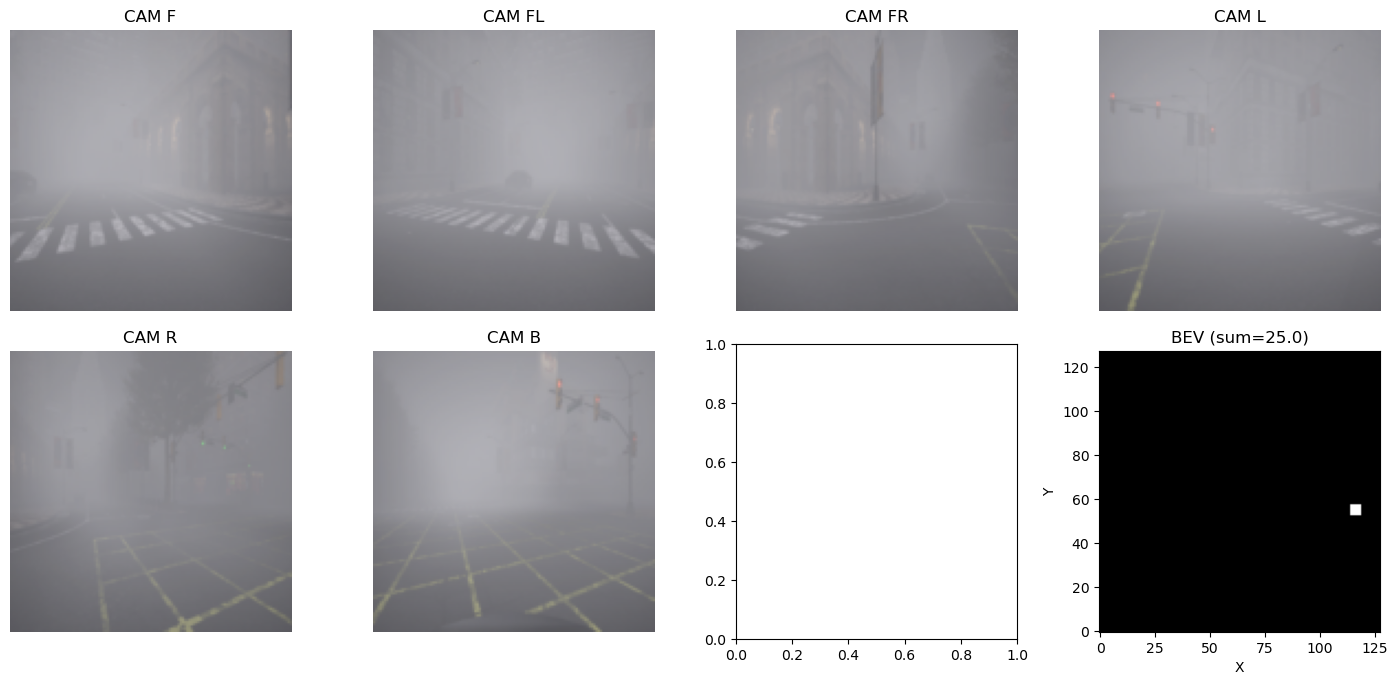

In [5]:
import matplotlib.pyplot as plt

def show_bev_sample(dataset, idx=0):
    imgs, bev, cond_id = dataset[idx]

    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    cams = ["F", "FL", "FR", "L", "R", "B"]

    # 6 camera views
    for i in range(6):
        ax = axes[i // 4][i % 4]
        img = imgs[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"CAM {cams[i]}")
        ax.axis("off")

    # BEV
    ax = axes[1][3]
    ax.imshow(bev[0].numpy(), cmap="gray", origin="lower")
    ax.set_title(f"BEV (sum={bev.sum().item():.1f})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    plt.tight_layout()
    plt.show()

show_bev_sample(dataset, idx=0)


In [6]:
import torch
from torch.utils.data import random_split, DataLoader

# 80/20 split
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val   = n_total - n_train

train_set, val_set = random_split(dataset, [n_train, n_val])

batch_size = 4  # you can tune this

train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set, batch_size=batch_size,
                          shuffle=False, num_workers=0)


In [7]:
import torch.nn.functional as F  # if not already imported

def dice_loss(logits, target, eps=1e-6):
    """
    logits: [B,1,H,W]  (raw outputs from BEVUNet)
    target: [B,1,H,W]  (BEV ground truth, 0/1)
    """
    prob = torch.sigmoid(logits)          # [B,1,H,W]
    target = target.float()

    # flatten over spatial dims
    prob_flat   = prob.view(prob.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    intersection = (prob_flat * target_flat).sum(dim=1)        # [B]
    union        = prob_flat.sum(dim=1) + target_flat.sum(dim=1) + eps

    dice = 2.0 * intersection / union                          # [B]
    return 1.0 - dice.mean()      # Dice loss = 1 - Dice score


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class BEVUNet(nn.Module):
    def __init__(self, in_ch=18, base_ch=32):
        super().__init__()

        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64

        self.conv2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*2, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32

        self.conv3 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*4, base_ch*4, 3, padding=1),
            nn.BatchNorm2d(base_ch*4),
            nn.ReLU(inplace=True),
        )

        # decoder
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch*2, base_ch*2, 3, padding=1),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        self.out = nn.Conv2d(base_ch, 1, 1)

    def forward(self, imgs6):  # imgs6: [B,6,3,H,W]
        B, V, C, H, W = imgs6.shape
        x = imgs6.view(B, V*C, H, W)  # [B,18,H,W]

        c1 = self.conv1(x)       # [B,32,128,128]
        p1 = self.pool1(c1)      # [B,32,64,64]

        c2 = self.conv2(p1)      # [B,64,64,64]
        p2 = self.pool2(c2)      # [B,64,32,32]

        c3 = self.conv3(p2)      # [B,128,32,32]

        u2 = self.up2(c3)        # [B,64,64,64]
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.dec2(u2)       # [B,64,64,64]

        u1 = self.up1(d2)        # [B,32,128,128]
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.dec1(u1)       # [B,32,128,128]

        logits = self.out(d1)    # [B,1,128,128]
        return logits


In [9]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BEVUNet().to(device)

# pos_weight_value = 20.0          # try 10, 20, 30 etc. if needed
# pos_weight = torch.tensor([pos_weight_value], device=device)

# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BEVUNet().to(device)

# ---- BCE with positive weighting ----
pos_weight_value = 20.0   # you can tune this (10–30)
pos_weight = torch.tensor([pos_weight_value], device=device)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ---- combined loss: BCE + λ * Dice ----
LAMBDA_DICE = 0.5   # start with 0.5, can tune

def bev_loss(logits, target):
    """
    Combined BEV loss:
      L = BCE_with_logits + λ * Dice_loss
    """
    loss_bce  = bce_loss(logits, target)
    loss_dice = dice_loss(logits, target)
    return loss_bce + LAMBDA_DICE * loss_dice

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



def run_epoch(loader, model, optimizer=None):
    training = optimizer is not None
    model.train(training)
    total_loss = 0.0
    n_batches = 0

    for imgs, bev, _ in loader:
        imgs = imgs.to(device)          # [B,6,3,128,128]
        bev  = bev.to(device)           # [B,1,128,128]

        logits = model(imgs)            # [B,1,128,128]
        #loss = criterion(logits, bev)
        loss   = bev_loss(logits, bev)

        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(n_batches, 1)


num_epochs = 15
best_val = float("inf")
best_state = None

for epoch in range(1, num_epochs+1):
    train_loss = run_epoch(train_loader, model, optimizer)
    val_loss   = run_epoch(val_loader, model, optimizer=None)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train: {train_loss:.4f} | val: {val_loss:.4f}")

torch.save(best_state, "bev_unet_multiview.pth")
print("Saved best model with val loss:", best_val)


Epoch 01 | train: 1.1592 | val: 1.1122
Epoch 02 | train: 1.0250 | val: 0.9858
Epoch 03 | train: 0.9599 | val: 0.9405
Epoch 04 | train: 0.9229 | val: 0.9150
Epoch 05 | train: 0.8951 | val: 0.8869
Epoch 06 | train: 0.8699 | val: 0.8853
Epoch 07 | train: 0.8479 | val: 0.8445
Epoch 08 | train: 0.8314 | val: 0.8203
Epoch 09 | train: 0.8137 | val: 0.8002
Epoch 10 | train: 0.7954 | val: 0.7963
Epoch 11 | train: 0.7796 | val: 0.7848
Epoch 12 | train: 0.7638 | val: 0.8037
Epoch 13 | train: 0.7542 | val: 0.7655
Epoch 14 | train: 0.7357 | val: 0.7420
Epoch 15 | train: 0.7253 | val: 0.7452
Saved best model with val loss: 0.7420334766308466


C:\Users\avant\AppData\Local\Temp\ipykernel_15072\761709181.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("bev_unet_multiview.pth", map_location=de

idx=0  condition=foggy  using thr=0.4


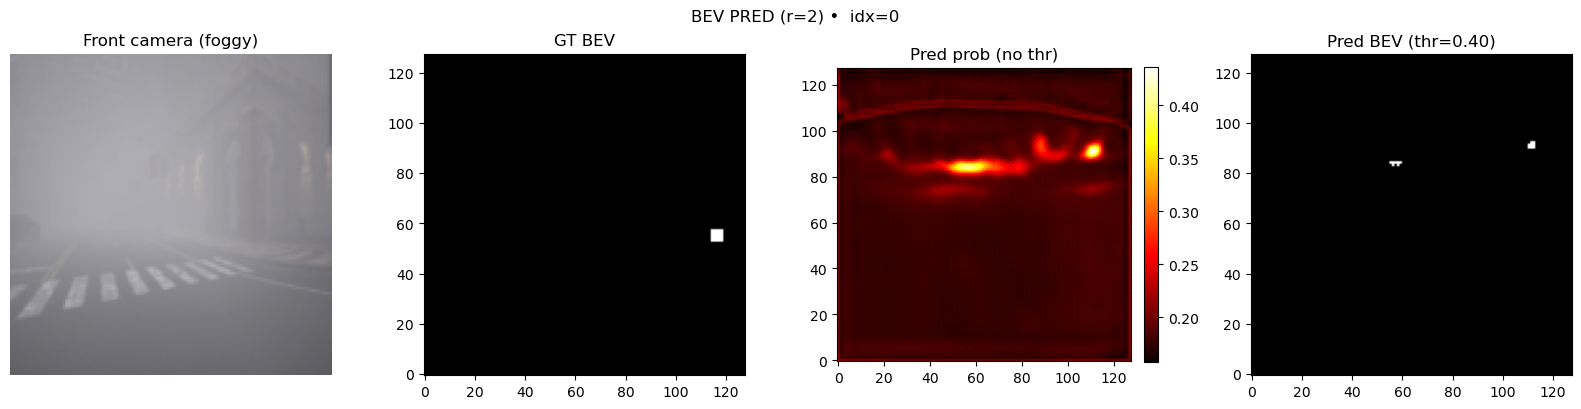

idx=5  condition=foggy  using thr=0.4


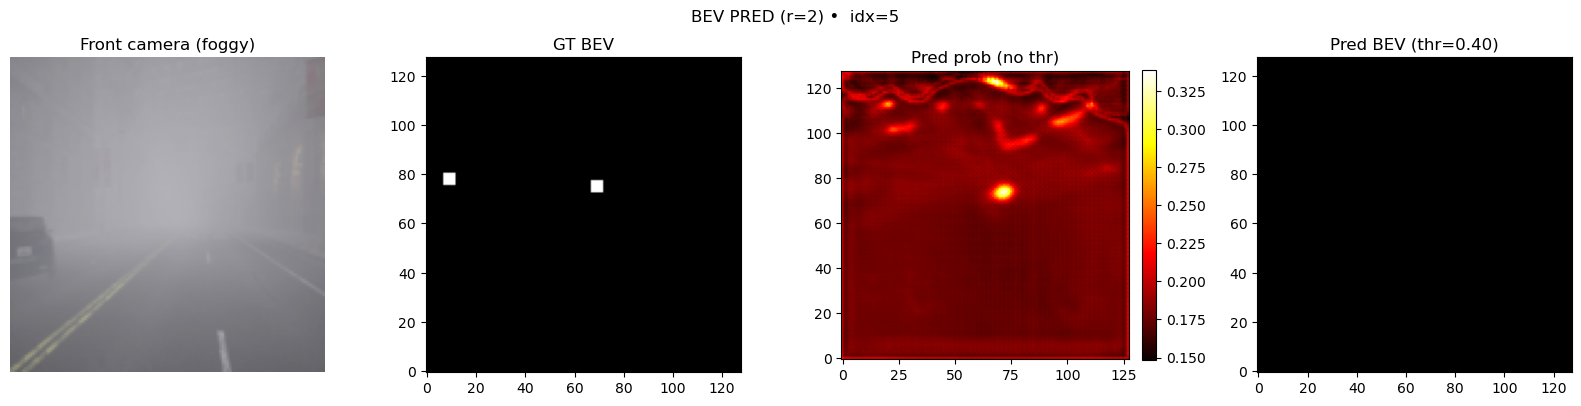

idx=20  condition=foggy  using thr=0.4


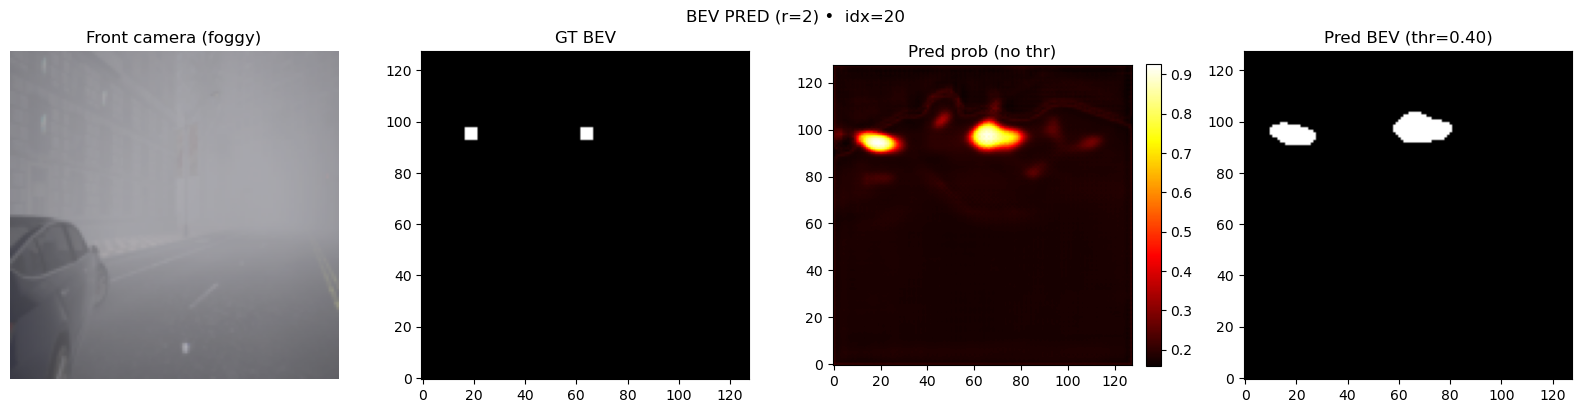

idx=50  condition=Rainy  using thr=0.45


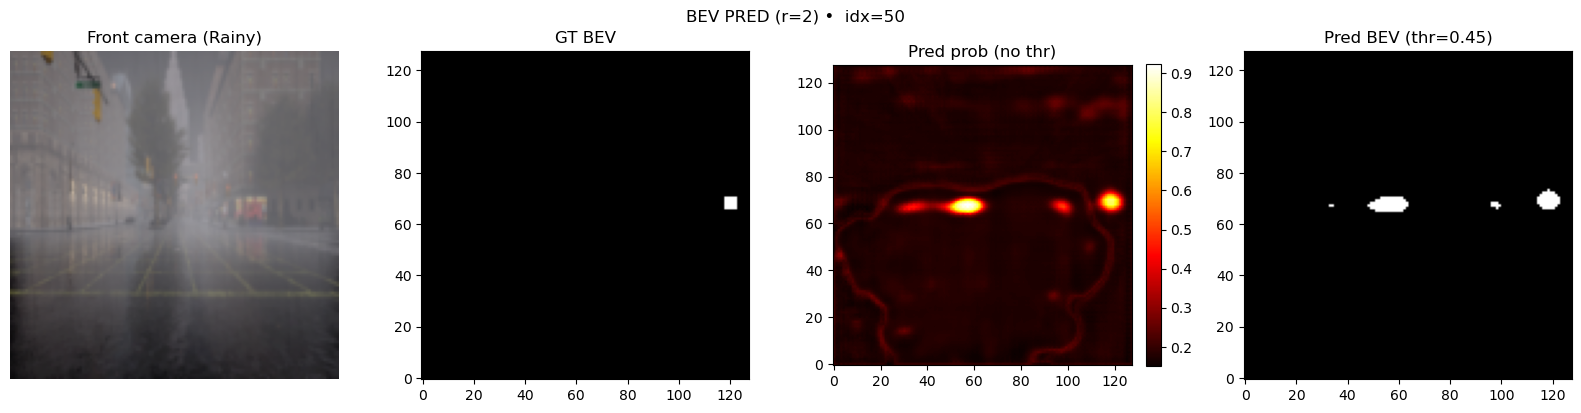

idx=100  condition=Rainy  using thr=0.45


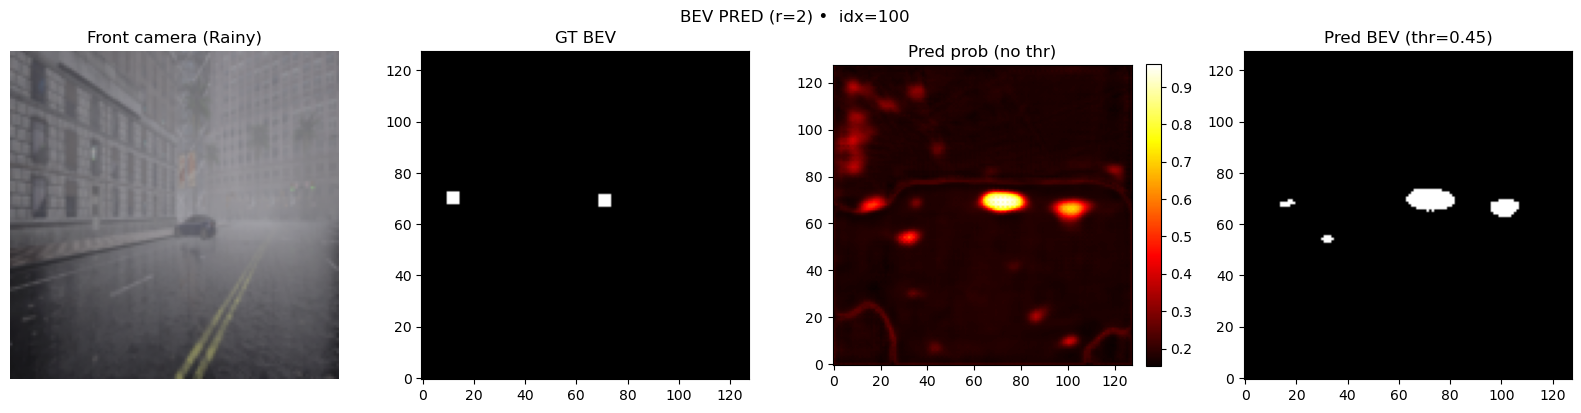

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# -------------------------------
# 1. Load best model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = BEVUNet().to(device)
state = torch.load("bev_unet_multiview.pth", map_location=device)
best_model.load_state_dict(state)
best_model.eval()

# -------------------------------
# 2. Per-weather thresholds
# -------------------------------
# dataset.conditions should be something like ["foggy", "Rainy", "clear"]
id_to_cond = {i: c for i, c in enumerate(dataset.conditions)}

# thresholds you want for each condition
COND_THR = {
    "clear": 0.55,   # clean
    "foggy": 0.40,   # foggy
    "rainy": 0.45,   # rainy
    "Rainy": 0.45,   # in case your list uses capital R
    "Foggy": 0.40,
}

# -------------------------------
# 3. Visualization helper
# -------------------------------
def show_prediction(dataset, idx, thr_bin, title_prefix=""):
    """
    Show:
      - front camera image
      - GT BEV
      - predicted probability heatmap
      - binarized predicted BEV

    thr_bin: threshold used to binarize the BEV prob map
    """
    # imgs: [6,3,H,W], bev_gt: [1,H,W], cond_id: int
    imgs, bev_gt, cond_id = dataset[idx]
    condition = id_to_cond[cond_id]

    with torch.no_grad():
        logits = best_model(imgs.unsqueeze(0).to(device))   # [1,1,H,W]
        prob   = torch.sigmoid(logits)[0, 0].cpu().numpy() # [H,W]

    pred_bev = (prob >= thr_bin).astype(np.float32)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # --------- Front camera ----------
    img0 = imgs[0].permute(1, 2, 0).numpy()
    img0 = (img0 * 0.5 + 0.5).clip(0, 1)
    axes[0].imshow(img0)
    axes[0].set_title(f"Front camera ({condition})")
    axes[0].axis("off")

    # --------- GT BEV ----------
    axes[1].imshow(bev_gt[0].numpy(), cmap="gray", origin="lower")
    axes[1].set_title("GT BEV")

    # --------- Probability heatmap ----------
    im = axes[2].imshow(prob, cmap="hot", origin="lower")
    axes[2].set_title("Pred prob (no thr)")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

    # --------- Thresholded BEV ----------
    axes[3].imshow(pred_bev, cmap="gray", origin="lower")
    axes[3].set_title(f"Pred BEV (thr={thr_bin:.2f})")

    plt.suptitle(title_prefix + f" idx={idx}")
    plt.tight_layout()
    plt.show()


# -------------------------------
# 4. Try a few samples with explicit per-weather thr
# -------------------------------
for i in [0, 5, 20, 50, 100]:
    if i >= len(dataset):
        continue

    # peek condition to choose threshold
    _, _, cond_id = dataset[i]
    condition = id_to_cond[cond_id]

    thr = COND_THR.get(condition, 0.35)  # fallback if unknown condition

    print(f"idx={i}  condition={condition}  using thr={thr}")
    show_prediction(dataset, idx=i, thr_bin=thr,
                    title_prefix="BEV PRED (r=2) • ")


idx=138  condition=clear  using thr=0.45


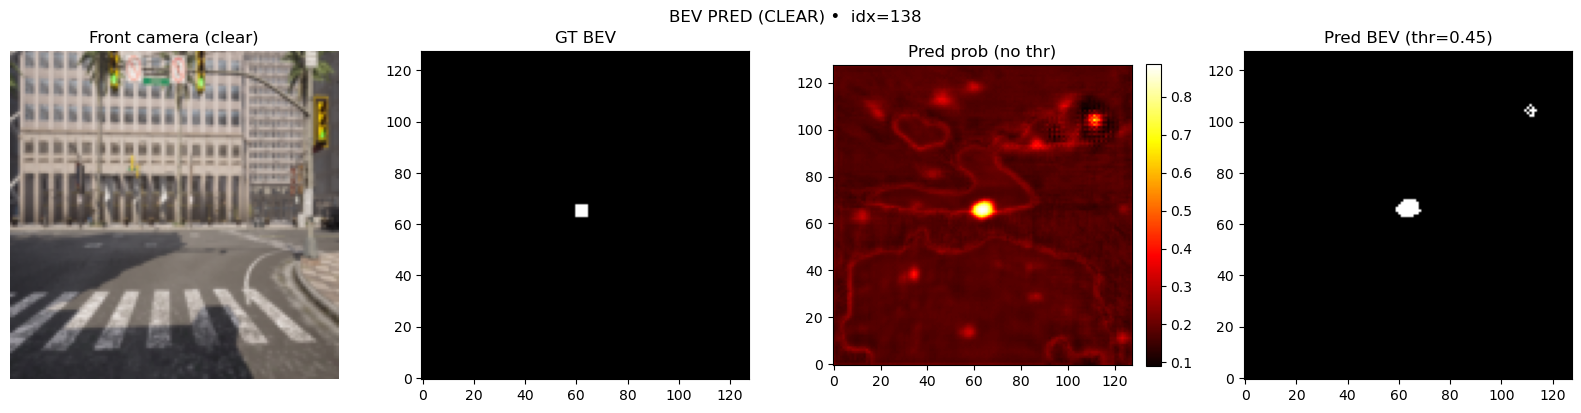

idx=139  condition=clear  using thr=0.45


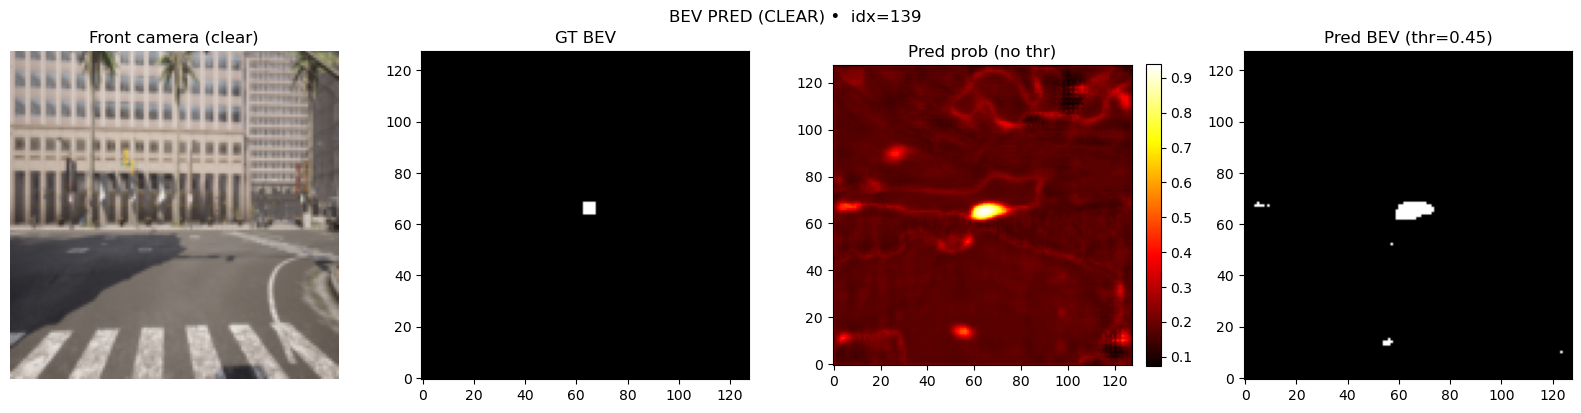

idx=140  condition=clear  using thr=0.45


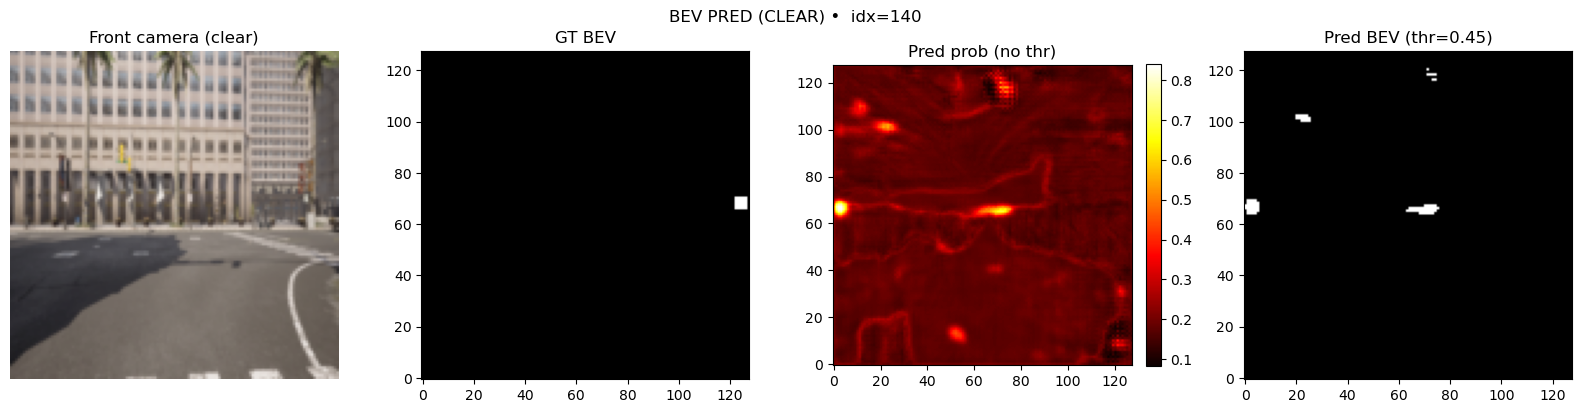

idx=141  condition=clear  using thr=0.45


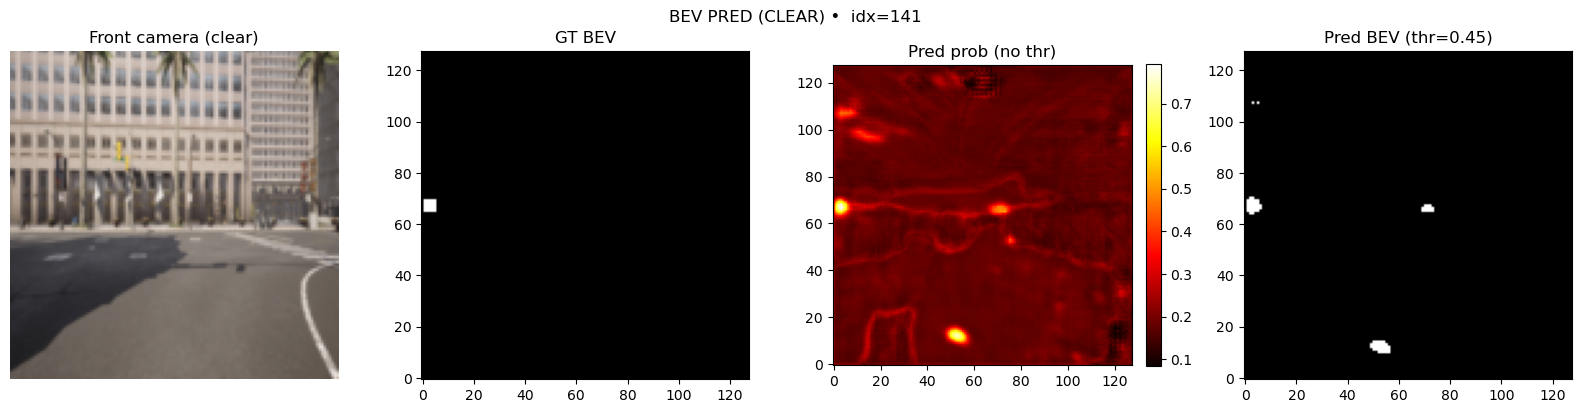

idx=142  condition=clear  using thr=0.45


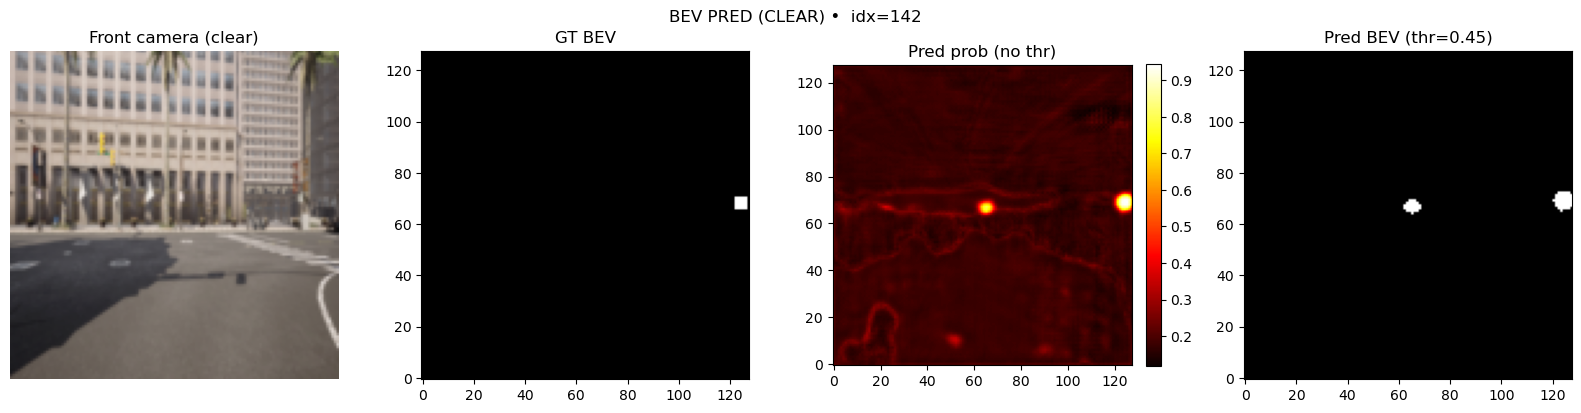

In [11]:
# -------------------------------
# Show ONLY clear-weather examples
# -------------------------------
CLEAR_THR = 0.45   # threshold for clear condition
num_examples = 5   # how many clear samples you want to visualize

count = 0
for idx in range(len(dataset)):
    imgs, bev_gt, cond_id = dataset[idx]
    condition = id_to_cond[cond_id]

    if condition.lower() == "clear":
        print(f"idx={idx}  condition=clear  using thr={CLEAR_THR}")
        show_prediction(
            dataset,
            idx=idx,
            thr_bin=CLEAR_THR,
            title_prefix="BEV PRED (CLEAR) • "
        )
        count += 1

    if count == num_examples:
        break


In [12]:
import torch
import numpy as np

# per-weather thresholds you chose
WEATHER_THR = {
    "clear": 0.45,
    "foggy": 0.30,
    "Rainy": 0.35,
}

def bev_metrics_per_weather(model, dataset):
    model.eval()
    
    # storage: {cond: {"iou": [...], "prec": [...], "rec": [...]} }
    stats = {}

    for idx in range(len(dataset)):
        imgs, bev_gt, cond_id = dataset[idx]
        cond = dataset.conditions[cond_id]

        thr = WEATHER_THR.get(cond, 0.35)  # default if key missing

        # ---------- forward ----------
        with torch.no_grad():
            logits = model(imgs.unsqueeze(0).to(device))      # [1,1,H,W]
            prob   = torch.sigmoid(logits)[0, 0].cpu().numpy()  # [H,W]

        # ---------- make pred + gt ----------
        pred = (prob >= thr).astype(np.float32)              # <-- pred DEFINED here
        gt   = bev_gt[0].cpu().numpy().astype(np.float32)

        # skip samples with completely empty target+prediction
        union = ((pred + gt) > 0).sum()
        if union == 0:
            continue

        # ---------- IoU ----------
        inter = (pred * gt).sum()
        iou   = inter / union

        # ---------- Precision / Recall ----------
        TP = inter
        FP = (pred * (1.0 - gt)).sum()
        FN = ((1.0 - pred) * gt).sum()

        prec = TP / (TP + FP + 1e-6)
        rec  = TP / (TP + FN + 1e-6)

        # store
        if cond not in stats:
            stats[cond] = {"iou": [], "prec": [], "rec": []}
        stats[cond]["iou"].append(iou)
        stats[cond]["prec"].append(prec)
        stats[cond]["rec"].append(rec)

    # average over samples
    out = {}
    for cond, d in stats.items():
        out[cond] = {
            "mIoU":   float(np.mean(d["iou"])),
            "Prec":   float(np.mean(d["prec"])),
            "Recall": float(np.mean(d["rec"])),
        }
    return out


In [13]:
metrics = bev_metrics_per_weather(best_model, dataset)
print(metrics)


{'foggy': {'mIoU': 0.10832173655318714, 'Prec': 0.11838274612998692, 'Recall': 0.7821666511344448}, 'Rainy': {'mIoU': 0.10131959953980364, 'Prec': 0.1020750625096138, 'Recall': 0.940597647119722}, 'clear': {'mIoU': 0.2021501490095277, 'Prec': 0.2039499437274164, 'Recall': 0.9537508023923676}}


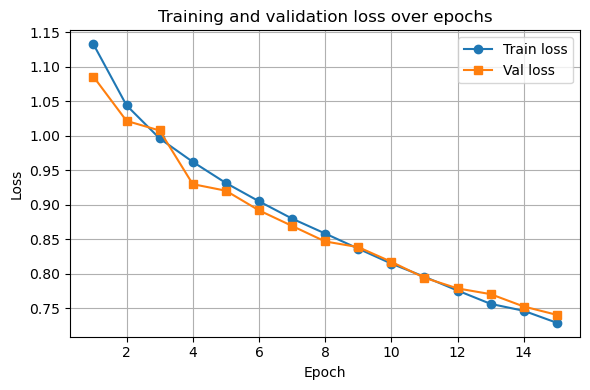

In [15]:
import matplotlib.pyplot as plt

# Epoch and loss data from the log
epochs = list(range(1, 16))
train_loss = [1.1326, 1.0441, 0.9962, 0.9623, 0.9317,
              0.9052, 0.8801, 0.8585, 0.8366, 0.8149,
              0.7959, 0.7759, 0.7566, 0.7466, 0.7292]
val_loss =   [1.0857, 1.0216, 1.0077, 0.9300, 0.9205,
              0.8921, 0.8695, 0.8470, 0.8388, 0.8175,
              0.7944, 0.7790, 0.7707, 0.7528, 0.7407]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, marker='o', label='Train loss')
plt.plot(epochs, val_loss, marker='s', label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss over epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('train_val_loss_curve.png', dpi=300)
plt.show()


In [16]:
import numpy as np
import torch

# ---------------------------------------------------
# 1. Average Precision (AP) for binary classification
# ---------------------------------------------------
def average_precision(scores, labels):
    """
    scores: 1D numpy array of predicted probabilities in [0, 1]
    labels: 1D numpy array of {0,1} ground-truth
    Returns scalar AP (area under precision–recall curve).
    """
    assert scores.shape == labels.shape
    # sort by descending score
    order = np.argsort(-scores)
    y_true = labels[order]

    tp = (y_true == 1).astype(np.float32)
    fp = (y_true == 0).astype(np.float32)

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)

    # avoid division by zero
    eps = 1e-8
    recalls = tp_cum / (tp.sum() + eps)
    precisions = tp_cum / (tp_cum + fp_cum + eps)

    # trapezoidal integration over recall
    ap = 0.0
    prev_r = 0.0
    for p, r in zip(precisions, recalls):
        ap += p * max(r - prev_r, 0.0)
        prev_r = r
    return ap


# ---------------------------------------------------
# 2. mAP per weather + overall
# ---------------------------------------------------
def bev_map_per_weather(model, dataset):
    model.eval()

    # map from condition name -> list of score arrays / label arrays
    scores_dict = {}
    labels_dict = {}

    for idx in range(len(dataset)):
        imgs, bev_gt, cond_id = dataset[idx]
        cond = dataset.conditions[cond_id]

        with torch.no_grad():
            logits = model(imgs.unsqueeze(0).to(device))   # [1,1,H,W]
            prob   = torch.sigmoid(logits)[0, 0].cpu().numpy()  # [H,W]

        gt = bev_gt[0].numpy().astype(np.uint8)  # [H,W], 0/1

        scores_dict.setdefault(cond, []).append(prob.ravel())
        labels_dict.setdefault(cond, []).append(gt.ravel())

    # compute AP per condition
    map_results = {}
    for cond in scores_dict.keys():
        scores = np.concatenate(scores_dict[cond], axis=0)
        labels = np.concatenate(labels_dict[cond], axis=0)
        ap = average_precision(scores, labels)
        map_results[cond] = ap

    # overall mAP across conditions
    overall_map = float(np.mean(list(map_results.values())))
    return map_results, overall_map


# ---------------------------------------------------
# 3. Run it and print
# ---------------------------------------------------
map_per_weather, map_all = bev_map_per_weather(best_model, dataset)

print("Per-weather mAP:")
for cond, ap in map_per_weather.items():
    print(f"  {cond:>6}: {ap:.4f}")

print(f"\nOverall mAP: {map_all:.4f}")


Per-weather mAP:
   foggy: 0.4279
   Rainy: 0.4938
   clear: 0.4710

Overall mAP: 0.4642
